In [62]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.datasets import TUDataset, Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GATv2Conv, GINConv, global_add_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE

In [7]:
root = './data/'

dataset = Planetoid(root, 'CORA')
dataset

Processing...
Done!


CORA()

In [8]:
print(len(dataset))

print(dataset.num_classes)

print(dataset.num_node_features)

1
7
1433


In [10]:
data = dataset[0]
data.num_nodes

2708

In [11]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [12]:
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
graph

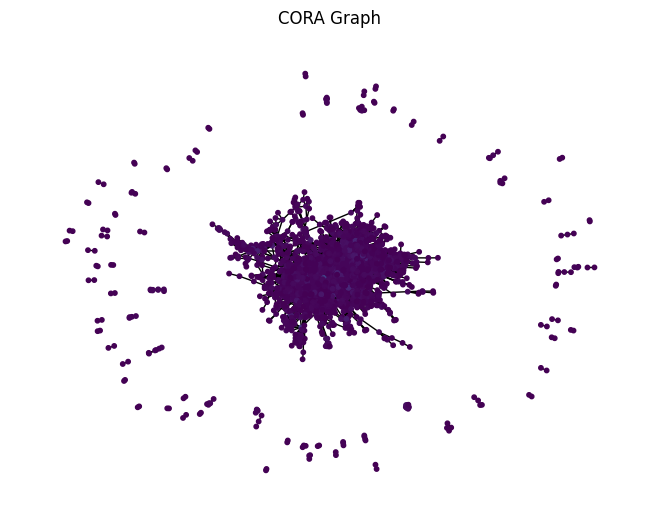

In [14]:
# calculates the degrees of all nodes
node_degrees = dict(graph.degree)

# creates a list of colors for nodes based on their degrees
node_colors = [node_degrees[node] for node in graph.nodes]

# graph
pos = nx.spring_layout(graph)

# draws nodes w colors based on its degree
nx.draw(graph, pos, with_labels=False, node_size=10, node_color=node_colors, cmap=plt.cm.viridis)

plt.title("CORA Graph")
plt.show()

In [33]:
average_degree = sum(dict(graph.degree()).values()) / len(graph)

if nx.is_connected(graph):
    diameter = nx.diameter(graph)

    average_path_length = nx.average_shortest_path_length(graph)
else:
    # if the graph is not connected
    diameter = None
    average_path_length = None

clustering_coefficient = nx.average_clustering(graph)

In [27]:
average_degree

3.8980797636632203

In [29]:
print(diameter) # graph is not connected, so Network Diameter is undefined

None


In [34]:
print(average_path_length) # graph is not connected, so average_path_lengths is undefined

None


In [35]:
clustering_coefficient

0.24067329850193728

# GCN

In [37]:
class GCNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

In [38]:
model = GCNModel(dataset.num_features, hidden_dim=16, num_classes=dataset.num_classes)
model

GCNModel(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [40]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

for epoch in range(200):
    train()

In [41]:
model.eval()
with torch.no_grad():
    logits = model(data)
    pred = logits.argmax(dim=1)
    train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    val_acc = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000, Validation Accuracy: 0.7500, Test Accuracy: 0.7760


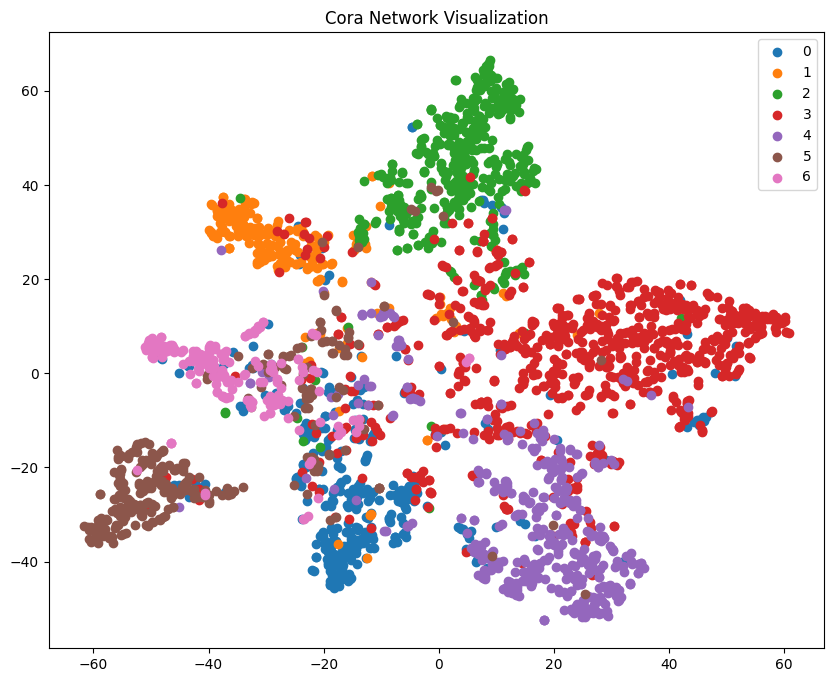

Test Accuracy: 0.7760


In [43]:
predicted_labels = pred.cpu().numpy()

def visualize_graph(embeddings, labels, title):
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)
    classes = np.unique(labels)
    
    plt.figure(figsize=(10, 8))
    for cls in classes:
        mask = (labels == cls)
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=str(cls))
    
    plt.title(title)
    plt.legend()
    plt.show()

visualize_graph(logits, data.y, "Cora Network Visualization")

# classification accuracy
test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy: {test_acc:.4f}")

# GATv2

In [45]:
model = GATv2Conv(
    in_channels=dataset.num_features,
    out_channels=128,
    heads=8,
    concat=True,
    negative_slope=0.2,
    dropout=0.6,
)


In [46]:
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def test():
    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum())
    acc = correct / int(data.test_mask.sum())
    return acc

for epoch in range(1, 201):
    train()
    test_acc = test()
    print(f'Epoch: {epoch:03d}, Test Accuracy: {test_acc:.4f}')


Epoch: 001, Test Accuracy: 0.3000
Epoch: 002, Test Accuracy: 0.4240
Epoch: 003, Test Accuracy: 0.4740
Epoch: 004, Test Accuracy: 0.5120
Epoch: 005, Test Accuracy: 0.5380
Epoch: 006, Test Accuracy: 0.5490
Epoch: 007, Test Accuracy: 0.5620
Epoch: 008, Test Accuracy: 0.5860
Epoch: 009, Test Accuracy: 0.5910
Epoch: 010, Test Accuracy: 0.6110
Epoch: 011, Test Accuracy: 0.6110
Epoch: 012, Test Accuracy: 0.6250
Epoch: 013, Test Accuracy: 0.6350
Epoch: 014, Test Accuracy: 0.6400
Epoch: 015, Test Accuracy: 0.6360
Epoch: 016, Test Accuracy: 0.6350
Epoch: 017, Test Accuracy: 0.6340
Epoch: 018, Test Accuracy: 0.6420
Epoch: 019, Test Accuracy: 0.6480
Epoch: 020, Test Accuracy: 0.6480
Epoch: 021, Test Accuracy: 0.6520
Epoch: 022, Test Accuracy: 0.6550
Epoch: 023, Test Accuracy: 0.6570
Epoch: 024, Test Accuracy: 0.6580
Epoch: 025, Test Accuracy: 0.6570
Epoch: 026, Test Accuracy: 0.6630
Epoch: 027, Test Accuracy: 0.6710
Epoch: 028, Test Accuracy: 0.6750
Epoch: 029, Test Accuracy: 0.6770
Epoch: 030, Te

In [47]:
def plot_cora_network(data, predicted_labels):
    G = nx.Graph()
    edge_index = data.edge_index.t().tolist()

    for i, j in edge_index:
        G.add_edge(i, j)

    pos = nx.spring_layout(G)
    labels = {i: predicted_labels[i] for i in range(len(predicted_labels))}

    nx.draw(G, pos, with_labels=True, node_color=predicted_labels, cmap=plt.get_cmap('jet'), node_size=50, font_size=6, font_color='black')
    plt.show()


In [48]:
model.eval()
output = model(data.x, data.edge_index)
predicted_labels = output.argmax(dim=1)

In [49]:
true_labels = data.y.numpy()
predicted_labels = predicted_labels.numpy()

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

Classification Accuracy: 77.73%


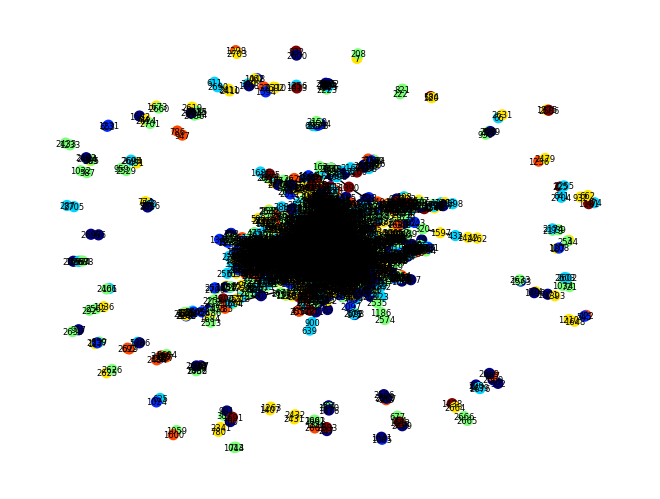

Classification Accuracy: 77.73%


In [50]:
plot_cora_network(data, predicted_labels)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

In [54]:
class GINNet(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(GINNet, self).__init__()

        self.conv1 = GINConv(nn.Sequential(nn.Linear(num_features, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels)))
        self.conv2 = GINConv(nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels)))
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

model = GINNet(dataset.num_features, dataset.num_classes, hidden_channels=64)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(dataset[0])
    loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
_, pred = model(dataset[0]).max(dim=1)
accuracy = accuracy_score(dataset.y[dataset.test_mask], pred[dataset.test_mask])
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 76.20%
